# Évaluation des prévisions d'ensemble à travers une analyse statistique sur des données de température et de vent (ARPEGE) 

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

np.set_printoptions(threshold=np.inf)

## VARIABLES

In [66]:
#############
# Variables #
#############

# Nombre de membres
kT = 34 
kV = 35
# Nombre de jours testés
NT = 12600
NV = 33090


## FONCTIONS

### probabilités

In [67]:
def prob(cond_prev, k, N):
    prob = np.sum(cond_prev, axis=1)/k
    return prob

### fréquence Np

In [68]:
def Np(prob):
    # np.unique nous sort la liste de valeurs (vals) qu'on regarde 
    # avec ses fréquences correspondentes (counts) 
    vals, counts = np.unique(prob, return_counts=True)
    return np.vstack([vals, counts]).T

### p'(p)

In [69]:
def pPrime(cond_obs, prob, Np):
    cond_obs= np.asarray(cond_obs, dtype=int)
    prob = np.asarray(prob)
    Np = np.asarray(Np)
    # On prend le vecteur de probas
    pVals = Np[:,0]
    # On créé une matrice booléenne qui indique les jours qui ont une proba p
        # Il s'agit de comparer toutes les probas avec les resultats de TOUS les jours
        # mask[j,i] = True sii prob[j] == pVals[i]
    mask = prob[:, None] == pVals[None,:] 
    # Pour chaque p, on additionne les cond_obs des jours où prob(jour) = p
        # mask et cond_obs agissent comme des indicatrices de p et epsilon 
        # en les mutipliant on obtient la double condition: evenement produit et p prévu
    sums = mask.T @ cond_obs 
    # On divise entre les fréquences Np
    p_prime = sums/Np[:,1]
    return np.column_stack([pVals, p_prime])

### High rate (H)

In [70]:
def H(cond_obs, prob, k):
    cond_obs = np.asarray(cond_obs, dtype=int)
    prob = np.asarray(prob)
    
    pCats = np.arange(k+1)/k
    N1 = cond_obs.sum()
    
    mask = prob[:, None] >= pCats[None, :]
    Hvals = (mask * cond_obs[:, None]).sum(axis=0) / N1
    return Hvals

### False Alarm (F)

In [71]:
def F(cond_obs, prob, k):
    cond_obs = np.asarray(cond_obs, dtype=int)
    prob = np.asarray(prob)
    
    indC = 1 - cond_obs
    pCats = np.arange(k+1)/k
    N0 = indC.sum()
    
    mask = prob[:, None] >= pCats[None, :]
    Fvals = (mask * indC[:, None]).sum(axis=0) / N0
    return Fvals

### probabilité climatologique

In [72]:
def pC(cond_obs, N):
    return np.mean(cond_obs)

### score de Brier

In [73]:
# Fiabilité
def BrierFiab(Np, pPrime, N): 
    Np = np.asarray(Np)
    pPrime = np.asarray(pPrime)
    return np.sum(Np[:,1] * (Np[:,0] - pPrime[:,1])**2) / N

# Résolution
def BrierRes(Np, pPrime, N, pc):
    Np = np.asarray(Np)
    pPrime = np.asarray(pPrime)
    return np.sum(Np[:,1] * (pPrime[:,1] - pc)**2) / N

# Score de Brier
def Brier(Np, pPrime, N, pc):
    return BrierFiab(Np, pPrime, N) - BrierRes(Np, pPrime, N, pc) + pc * (1-pc)

# Brier Skill Score
def BSS(Np, pPrime, N, pc):
    bf = BrierFiab(Np, pPrime, N)
    br = BrierRes(Np, pPrime, N, pc)
    bi = pc * (1-pc)
    return (br - bf)/bi

## MAIN

In [74]:
# DONNÉES
#########
dfT = pd.read_csv("donnees_test_temperature.txt", delim_whitespace=True, header=None)
dfV = pd.read_csv("donnees_test_vent.txt", delim_whitespace=True, header=None)

# Vecteurs d'observations
obsT = dfT.iloc[:, -1] 
obsV = dfV.iloc[:, -1] 

# Matrices de prévisions
prevT = dfT.iloc[:, 0:kT]
prevV = dfV.iloc[:, 0:kV]

prevT = np.array(prevT)
prevV = np.array(prevV)

In [75]:
# ÉLÉMENTS DE CALCUL
####################

# Condition à établir
condT = np.median(obsT)
condV = np.median(obsV)

# Événements théoriques
ET = prevT > condT
EV = prevV > condV 

# Événements observés
OT = obsT > condT
OV = obsV > condV

In [76]:
# Vecteurs de probabilités par jour
probT = prob(ET, kT, NT)
probV = prob(EV, kV, NV)

# Matrices de fréquences de probabilités
NpT = Np(probT)
NpV = Np(probV)

NpT = np.array(NpT)
NpV = np.array(NpV)

# Matrices de fréquences réelles (p'(p))
pPrimeT = pPrime(OT, probT, NpT)
pPrimeV = pPrime(OV, probV, NpV)

pPrimeT = np.array(pPrimeT)
pPrimeV = np.array(pPrimeV)

# Probabilité climatologique
pcT = pC(OT, NT)
pcV = pC(OV, NV)

# H
HT = H(OT, probT, kT) 
HV = H(OV, probV, kV) 

# F
FT = F(OT, probT, kT) 
FV = F(OV, probV, kV) 

## DIAGRAMMES

### diagramme de fiabilité

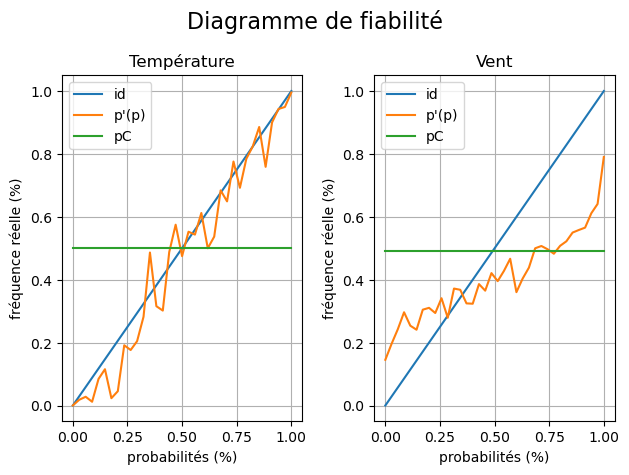

In [77]:
# -- FIGURE 1 --
fig1, (ax1, ax2) = plt.subplots(1,2)

fig1.suptitle("Diagramme de fiabilité", fontsize=16)

# --- Coté gauche: témperature ---
ax1.plot(pPrimeT[:,0], pPrimeT[:,0], label="id")
ax1.plot(pPrimeT[:,0], pPrimeT[:, 1], label="p'(p)")
ax1.plot(pPrimeT[:,0], np.full((len(pPrimeT),), pcT), label="pC")
ax1.set_title("Température")
ax1.set_xlabel("probabilités (%)")
ax1.set_ylabel("fréquence réelle (%)")
ax1.legend() 
ax1.grid(True)

# --- Coté droit: vent ---
ax2.plot(pPrimeV[:,0], pPrimeV[:,0], label="id")
ax2.plot(pPrimeV[:,0], pPrimeV[:, 1], label="p'(p)")
ax2.plot(pPrimeV[:,0], np.full((len(pPrimeV),), pcV), label="pC")
ax2.set_title("Vent")
ax2.set_xlabel("probabilités (%)")
ax2.set_ylabel("fréquence réelle (%)")
ax2.legend()
ax2.grid(True)

plt.tight_layout()

### diagramme d'acuité

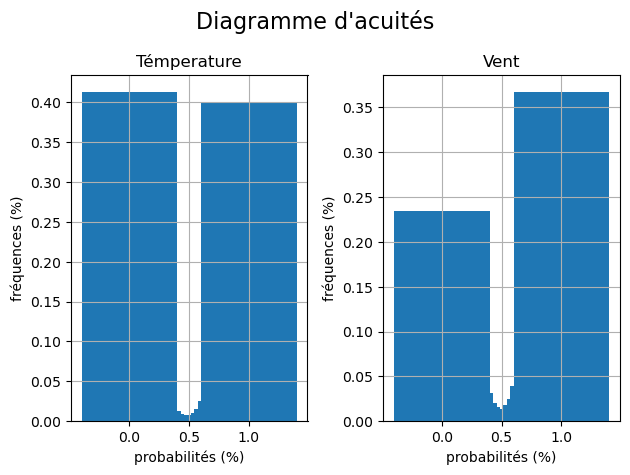

In [78]:
# -- FIGURE 2 --
fig2, (ax1, ax2) = plt.subplots(1,2)
fig2.suptitle("Diagramme d'acuités", fontsize=16)


# --- Coté gauche: témperature ---
ax1.bar(NpT[:,0], NpT[:,1]/NT, width= 0.8)
ax1.set_title("Témperature")
ax1.set_xlabel("probabilités (%)")
ax1.set_ylabel("fréquences (%)")
ax1.grid(True)

# --- Coté droit: vent ---
ax2.bar(NpV[:,0], NpV[:,1]/NV, width= 0.8)
ax2.set_title("Vent")
ax2.set_xlabel("probabilités (%)")
ax2.set_ylabel("fréquences (%)")
ax2.grid(True)

plt.tight_layout()

### courbe ROC

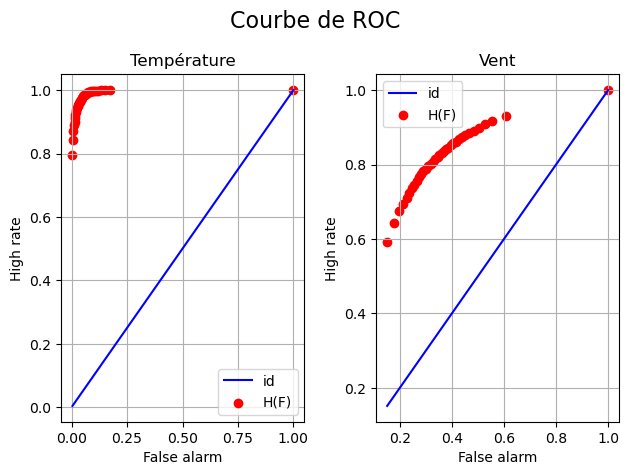

In [79]:
# -- FIGURE 3 --

fig3, (ax1, ax2) = plt.subplots(1,2)
fig3.suptitle("Courbe de ROC", fontsize=16)


# --- Coté gauche: témperature ---
ax1.plot(FT, FT, label="id", color='blue')
ax1.scatter(FT, HT, label="H(F)", color='red')
ax1.set_title("Température")
ax1.set_xlabel("False alarm")
ax1.set_ylabel("High rate")
ax1.legend() 
ax1.grid(True)

# --- Coté droit: vent ---
ax2.plot(FV, FV, label="id", color='blue')
ax2.scatter(FV, HV, label="H(F)", color='red')
ax2.set_title("Vent")
ax2.set_xlabel("False alarm")
ax2.set_ylabel("High rate")
ax2.legend() 
ax2.grid(True)

plt.tight_layout()

### Au délà

In [80]:
# VARIABLES
###########
kVa = 35
NVa = 12600

# DONNÉES
#########
dfVa = pd.read_csv("donnees_test_vent_analyse.txt", delim_whitespace=True, header=None)
obsVa = dfVa.iloc[:, -1] 
prevVa = dfVa.iloc[:, 0:kVa]
prevVa = np.array(prevVa)

In [81]:
# ÉLÉMENTS DE CALCUL
####################
# On rédefinit les conditions
condT90 = np.percentile(obsT, 90)
condV90 = np.percentile(obsV, 90)

# Pour le cas d'analyse on s'intéresse aux deux conditions
condVa = np.median(obsVa)
condVa90 = np.percentile(obsVa, 90)

# Événements théoriques
ET90 = prevT > condT90
EV90 = prevV > condV90
EVa = prevVa > condVa
EVa90 = prevVa > condVa90

# Événements observés
OT90 = obsT > condT90
OV90 = obsV > condV90
OVa = obsVa > condVa
OVa90 = obsVa > condVa90

# Vecteurs de probabilités par jour
probT90 = prob(ET90, kT, NT)
probV90 = prob(EV90, kV, NV)
probVa = prob(EVa, kVa, NVa)
probVa90 = prob(EVa90, kVa, NVa)

# Matrices de fréquences de probabilités
NpT90 = Np(probT90)
NpV90 = Np(probV90)
NpVa = Np(probVa)
NpVa90 = Np(probVa90)

NpT90 = np.array(NpT90)
NpV90 = np.array(NpV90)
NpVa = np.array(NpVa)
NpVa90 = np.array(NpVa90)

# Matrices de fréquences réelles (p'(p))
pPrimeT90 = pPrime(OT90, probT90, NpT90)
pPrimeV90 = pPrime(OV90, probV90, NpV90)
pPrimeVa = pPrime(OVa, probVa, NpVa)
pPrimeVa90 = pPrime(OVa90, probVa90, NpVa90)

pPrimeT90 = np.array(pPrimeT90)
pPrimeV90 = np.array(pPrimeV90)
pPrimeVa = np.array(pPrimeVa)
pPrimeVa90 = np.array(pPrimeVa90)

# Probabilité climatologique
pcT90 = pC(OT90, NT)
pcV90 = pC(OV90, NV)
pcVa = pC(OVa, NVa)
pcVa90 = pC(OVa90, NVa)

# H
HT90 = H(OT90, probT90, kT) 
HV90 = H(OV90, probV90, kV) 
HVa = H(OVa, probVa, kVa) 
HVa90 = H(OVa90, probVa90, kVa) 

# F
FT90 = F(OT90, probT90, kT) 
FV90 = F(OV90, probV90, kV) 
FVa = F(OVa, probVa, kVa) 
FVa90 = F(OVa90, probVa90, kVa) 

### diagramme de fiabilité

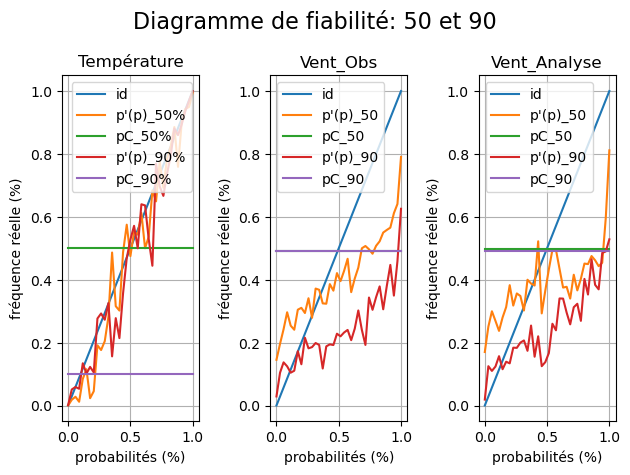

In [82]:
# -- FIGURE 4 --
fig4, (ax1, ax2, ax3) = plt.subplots(1,3)
fig4.suptitle("Diagramme de fiabilité: 50 et 90", fontsize=16)

# --- Coté gauche: témperature ---
ax1.plot(pPrimeT[:,0], pPrimeT[:,0], label="id")
ax1.plot(pPrimeT[:,0], pPrimeT[:, 1], label="p'(p)_50%")
ax1.plot(pPrimeT[:,0], np.full((len(pPrimeT),), pcT), label="pC_50%")
ax1.plot(pPrimeT90[:,0], pPrimeT90[:, 1], label="p'(p)_90%")
ax1.plot(pPrimeT90[:,0], np.full((len(pPrimeT90),), pcT90), label="pC_90%")
ax1.set_title("Température")
ax1.set_xlabel("probabilités (%)")
ax1.set_ylabel("fréquence réelle (%)")
ax1.legend() 
ax1.grid(True)

# --- Milieu: vent (obs) ---
ax2.plot(pPrimeV[:,0], pPrimeV[:,0], label="id")
ax2.plot(pPrimeV[:,0], pPrimeV[:, 1], label="p'(p)_50")
ax2.plot(pPrimeV[:,0], np.full((len(pPrimeV),), pcV), label="pC_50")
ax2.plot(pPrimeV90[:,0], pPrimeV90[:, 1], label="p'(p)_90")
ax2.plot(pPrimeV90[:,0], np.full((len(pPrimeV90),), pcV), label="pC_90")
ax2.set_title("Vent_Obs")
ax2.set_xlabel("probabilités (%)")
ax2.set_ylabel("fréquence réelle (%)")
ax2.legend()
ax2.grid(True)

# --- Coté droit: vent (analyse) ---
ax3.plot(pPrimeV[:,0], pPrimeV[:,0], label="id")
ax3.plot(pPrimeVa[:,0], pPrimeVa[:, 1], label="p'(p)_50")
ax3.plot(pPrimeVa[:,0], np.full((len(pPrimeVa),), pcVa), label="pC_50")
ax3.plot(pPrimeVa90[:,0], pPrimeVa90[:, 1], label="p'(p)_90")
ax3.plot(pPrimeVa90[:,0], np.full((len(pPrimeVa90),), pcV), label="pC_90")
ax3.set_title("Vent_Analyse")
ax3.set_xlabel("probabilités (%)")
ax3.set_ylabel("fréquence réelle (%)")
ax3.legend()
ax3.grid(True)

plt.tight_layout()

### diagramme d'acuité

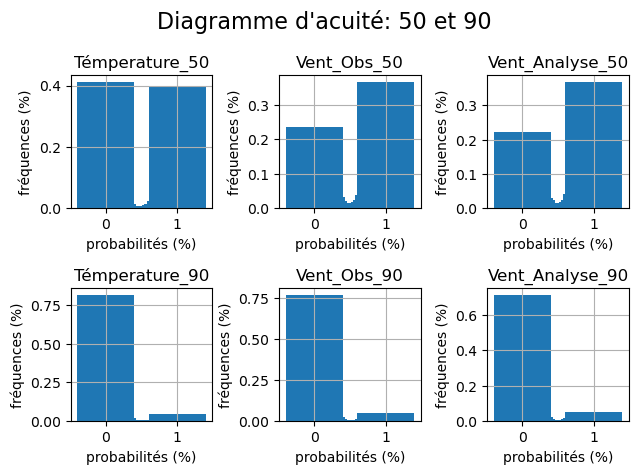

In [83]:
# -- FIGURE 5 --
fig5, axs = plt.subplots(2,3)
fig5.suptitle("Diagramme d'acuité: 50 et 90", fontsize=16)

# --- Coté gauche: témperature ---
axs[0,0].bar(NpT[:,0], NpT[:,1]/NT, width= 0.8)
axs[0,0].set_title("Témperature_50")
axs[0,0].set_xlabel("probabilités (%)")
axs[0,0].set_ylabel("fréquences (%)")
axs[0,0].grid(True)

axs[1,0].bar(NpT90[:,0], NpT90[:,1]/NT, width= 0.8)
axs[1,0].set_title("Témperature_90")
axs[1,0].set_xlabel("probabilités (%)")
axs[1,0].set_ylabel("fréquences (%)")
axs[1,0].grid(True)

# --- Milieu: vent (obs) ---
axs[0,1].bar(NpV[:,0], NpV[:,1]/NV, width= 0.8)
axs[0,1].set_title("Vent_Obs_50")
axs[0,1].set_xlabel("probabilités (%)")
axs[0,1].set_ylabel("fréquences (%)")
axs[0,1].grid(True)

axs[1,1].bar(NpV90[:,0], NpV90[:,1]/NV, width= 0.8)
axs[1,1].set_title("Vent_Obs_90")
axs[1,1].set_xlabel("probabilités (%)")
axs[1,1].set_ylabel("fréquences (%)")
axs[1,1].grid(True)

# --- Coté droit: vent (analyse) ---
axs[0,2].bar(NpVa[:,0], NpVa[:,1]/NVa, width= 0.8)
axs[0,2].set_title("Vent_Analyse_50")
axs[0,2].set_xlabel("probabilités (%)")
axs[0,2].set_ylabel("fréquences (%)")
axs[0,2].grid(True)

axs[1,2].bar(NpVa90[:,0], NpVa90[:,1]/NVa, width= 0.8)
axs[1,2].set_title("Vent_Analyse_90")
axs[1,2].set_xlabel("probabilités (%)")
axs[1,2].set_ylabel("fréquences (%)")
axs[1,2].grid(True)

plt.tight_layout()


### courbe de ROC

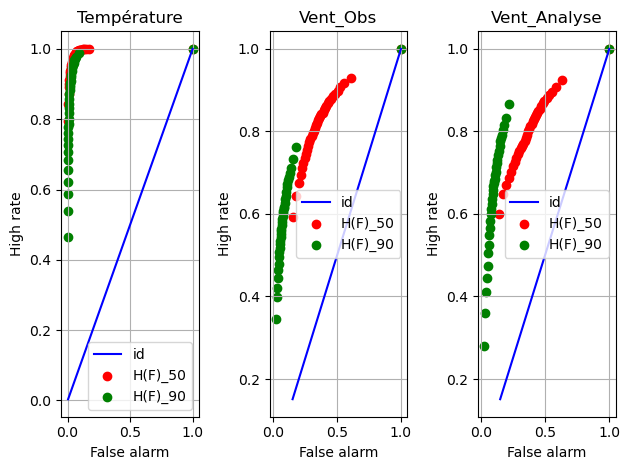

In [84]:
# -- FIGURE 6 --
fig6, (ax1, ax2, ax3) = plt.subplots(1,3)
fig3.suptitle("Courbe de ROC: 50 et 90", fontsize=16)


# --- Coté gauche: témperature ---
ax1.plot(FT, FT, label="id", color='blue')
ax1.scatter(FT, HT, label="H(F)_50", color='red')
ax1.scatter(FT90, HT90, label="H(F)_90", color='green')
ax1.set_title("Température")
ax1.set_xlabel("False alarm")
ax1.set_ylabel("High rate")
ax1.legend() 
ax1.grid(True)

# --- Milieu: vent (obs) ---
ax2.plot(FV, FV, label="id", color='blue')
ax2.scatter(FV, HV, label="H(F)_50", color='red')
ax2.scatter(FV90, HV90, label="H(F)_90", color='green')
ax2.set_title("Vent_Obs")
ax2.set_xlabel("False alarm")
ax2.set_ylabel("High rate")
ax2.legend() 
ax2.grid(True)

# --- Coté droit: vent (analyse) ---
ax3.plot(FV, FV, label="id", color='blue')
ax3.scatter(FVa, HVa, label="H(F)_50", color='red')
ax3.scatter(FVa90, HVa90, label="H(F)_90", color='green')
ax3.set_title("Vent_Analyse")
ax3.set_xlabel("False alarm")
ax3.set_ylabel("High rate")
ax3.legend() 
ax3.grid(True)

plt.tight_layout()